In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from obspy import read_inventory, UTCDateTime
from importlib import reload
from flovopy.asl.wrappers import run_single_event, find_event_files, run_all_events
from flovopy.core.mvo import dome_location, REGION_DEFAULT
from flovopy.processing.sam import VSAM, DSAM 
from flovopy.asl.config import ASLConfig, tweak_config

# Core ASL + utilities
from flovopy.asl.asl import ASL
from flovopy.asl.wrappers import asl_sausage
from flovopy.asl.grid import Grid, make_grid
from flovopy.asl.distances import compute_or_load_distances, distances_signature
from flovopy.asl.ampcorr import AmpCorr, AmpCorrParams
from flovopy.asl.misfit import StdOverMeanMisfit, R2DistanceMisfit, LinearizedDecayMisfit
from flovopy.asl.map import topo_map

# --- Diagnostics / comparisons ---
from flovopy.asl.diagnostics import extract_asl_diagnostics, compare_asl_sources

# --- Simulation helpers ---
from flovopy.asl.simulate import simulate_SAM, plot_SAM, synthetic_source_from_grid

# -------------------------- Config --------------------------
# directories
HOME = Path.home()
PROJECTDIR      = HOME / "Dropbox" / "BRIEFCASE" / "SSADenver"
LOCALPROJECTDIR = HOME / "work" / "PROJECTS" / "SSADenver_local"
OUTPUT_DIR      = LOCALPROJECTDIR / "ASL_RESULTS_LAPTOP"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
INPUT_DIR       = PROJECTDIR / "ASL_inputs" / "biggest_pdc_events"
GLOBAL_CACHE    = PROJECTDIR / "asl_global_cache"
METADATA_DIR    = PROJECTDIR / "metadata" 
STATION_CORRECTIONS_DIR = PROJECTDIR / "station_correction_analysis"

# master files
INVENTORY_XML   = METADATA_DIR / "MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT     = METADATA_DIR / "MONTSERRAT_DEM_WGS84_MASTER.tif"
GRIDFILE_DEFAULT= METADATA_DIR / "MASTER_GRID_MONTSERRAT.pkl"

# parameters for envelopes and cross-correlation
SMOOTH_SECONDS  = 1.0
MAX_LAG_SECONDS = 8.0
MIN_XCORR       = 0.5

# other parameters
DIST_MODE = "3d" # or 2d. will essentially squash Montserrat topography and stations onto a sea-level plane, ignored elevation data, e.g. for computing distances

# Inventory of Montserrat stations
INV     = read_inventory(INVENTORY_XML)
print(f"[INV] Networks: {len(INV)}  Stations: {sum(len(n) for n in INV)}  Channels: {sum(len(sta) for net in INV for sta in net)}")

# Montserrat station corrections estimated from regionals
station_corrections_csv = STATION_CORRECTIONS_DIR / "station_gains_intervals.csv"
annual_station_corrections_csv = STATION_CORRECTIONS_DIR / "station_gains_intervals_by_year.csv"
station_corrections_df = pd.read_csv(station_corrections_csv)
annual_station_corrections_df = pd.read_csv(annual_station_corrections_csv)

# Montserrat pre-defined Grid (from 02 tutorial)
gridobj = Grid.load(GRIDFILE_DEFAULT)
landgridobj = Grid.load(GLOBAL_CACHE / "land" / "Grid_9c2fd59b.pkl")

# Montserrat constants
print("Dome (assumed source) =", dome_location)

# Parameters to pass for making pygmt topo maps
topo_kw = {
    "inv": INV,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "frame": True,
    "dome_location": dome_location,
    "topo_color": False,
}

[INV] Networks: 1  Stations: 48  Channels: 77
[INFO] Grid loaded from /Users/thompsong/Dropbox/BRIEFCASE/SSADenver/metadata/MASTER_GRID_MONTSERRAT.pkl
[INFO] Grid loaded from /Users/thompsong/Dropbox/BRIEFCASE/SSADenver/asl_global_cache/land/Grid_9c2fd59b.pkl
Dome (assumed source) = {'lat': 16.7106, 'lon': -62.17747, 'elev': 1000.0}


In [2]:
from obspy import read, UTCDateTime
from flovopy.processing.sam import VSAM
from flovopy.processing.envelopes import plot_stream_with_envelopes
import random

# events and wrappers
event_files = list(find_event_files(INPUT_DIR))
'''
eventcsvfile = Path(OUTPUT_DIR) / "mseed_files.csv"
if not eventcsvfile.is_file():
    rows = [{"num": num, "f": str(f)} for num, f in enumerate(event_files)]
    df = pd.DataFrame(rows)
    df.to_csv(eventcsvfile, index=False)
'''
best_file_nums  = [35, 36, 40, 52, 82, 83, 84, 116, 310, 338]
best_event_files = [event_files[i] for i in best_file_nums]
print(f'Best miniseed files are: {best_event_files}')


st = read(best_event_files[0]).select(component='Z')      # main
for tr in st:
    tr.stats.units = 'm/s'
    tr.stats.distance = np.random.uniform(0.5, 10.0)
env = VSAM(stream=st, sampling_interval=1.0).to_stream(metric='mean')
print(st)
print(env)

Best miniseed files are: ['/Users/thompsong/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-08-05-1840-17S.MVO___019.cleaned', '/Users/thompsong/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-08-07-0441-43S.MVO___019.cleaned', '/Users/thompsong/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-09-14-1900-58S.MVO___019.cleaned', '/Users/thompsong/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2000-11-26-2123-08S.MVO___019.cleaned', '/Users/thompsong/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2006-04-12-0025-40S.MVO___031.cleaned', '/Users/thompsong/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2006-04-13-1534-00S.MVO___031.cleaned', '/Users/thompsong/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2006-04-14-1024-25S.MVO___031.cleaned', '/Users/thompsong/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2006-12-02-0448-14S.MVO___025.cleaned', '/Users/thompsong/Dropbox/BRIEFCASE/SSADenver/

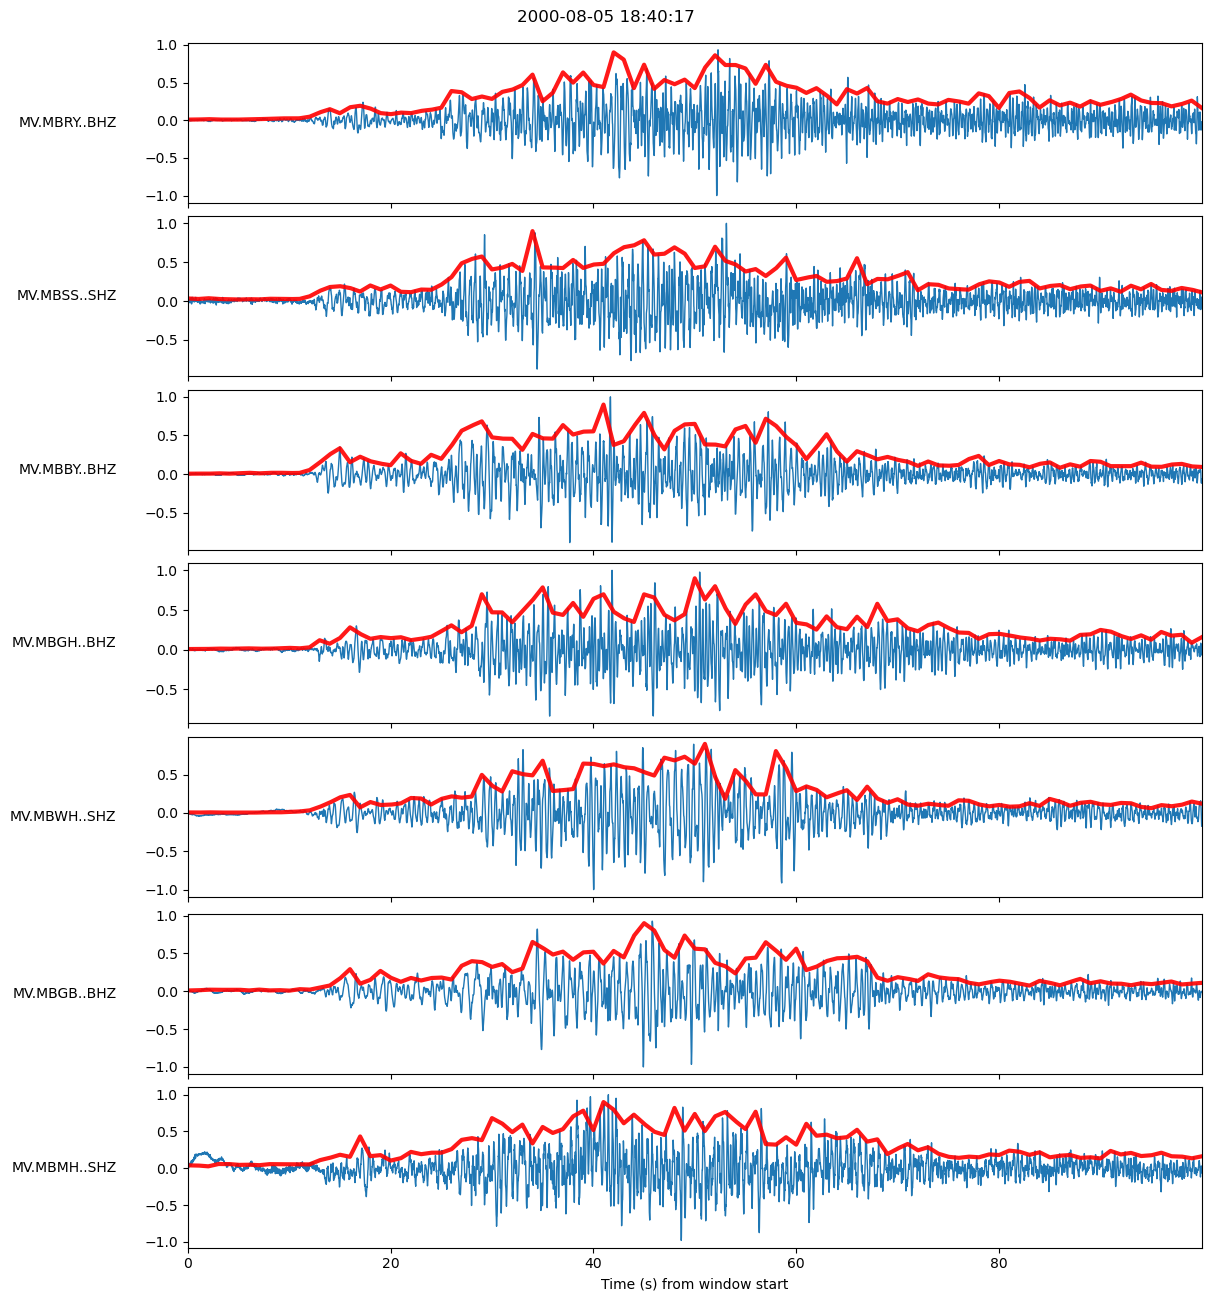

In [10]:
# Record section with reduced time at 3.5 km/s:
t0 = st[0].stats.starttime
t1 = st[0].stats.endtime
t1 = t0+100
'''
fig, _ = plot_stream_with_envelopes(
    st, env,
    time_window=(t0, t1),
    match="net.sta.cha",
    mode="auto",                        # switches to "section" if distance exists
    reduction_velocity_km_s=3.5,
    normalize="trace",
    #normalize=None,
    trace_scale=1.0,
    line_kwargs={"lw": 0.6},
    #section_env_kwargs={"lw":10.0, "alpha": 0.8},
    env_kwargs  = {"lw": 2.5, "alpha": 0.9},
    suptitle="Record Section with Envelopes",
)
# fig.show()
'''
fig, axes = plot_stream_with_envelopes(
    st, env,
    time_window=(t0, t1),
    #mode="section",
    mode='stacked',
    reduction_velocity_km_s=3.0,
    normalize="trace",
    trace_scale=1.0,
    # make traces black
    line_kwargs={"lw": 1.0},
    # envelopes in stacked mode (if you use it)
    env_kwargs={"color": "r", "lw": 3.0},
    # envelopes in section mode
    section_env_kwargs={"color": "r", "lw": 3.0},
    section_height_per_trace=2.0,   # bigger per-trace height
    section_min_height=6.0,         # min figure height
    suptitle=st[0].stats.starttime.strftime('%Y-%m-%d %H:%M:%S'),
    annotation_kwargs={'fontsize':12}
)